LOADING AND PRE-PROCESSING THE DATA

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU


stock_data = yf.download('NKE', start='2010-01-01')


print(stock_data.head())

# Using only the 'Close' price for prediction
data = stock_data[['Close']]

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Preparing the dataset for training
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60  # Using 60 days of data to predict the next day's price
X, y = create_dataset(scaled_data, time_step)

# Splitting the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Reshaping the input to be [samples, time steps, features] which is required for GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)






[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low    Close  Adj Close    Volume
Date                                                                     
2010-01-04  16.514999  16.517500  16.280001  16.3375  13.708188  11972400
2010-01-05  16.285000  16.447500  16.174999  16.4025  13.762720   6275200
2010-01-06  16.350000  16.422501  16.235001  16.3025  13.678821  13399200
2010-01-07  16.280001  16.500000  16.262501  16.4625  13.813066   7187600
2010-01-08  16.447500  16.462500  16.235001  16.4300  13.785796   7249600


MODEL TRAINING

In [3]:
# Building the GRU model
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit(X_train, y_train, batch_size=1, epochs=7)

Epoch 1/7


2024-07-10 18:17:38.002421: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 18:17:38.032338: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/nitinspatel/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


2872/2872 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - loss: 0.0018
Epoch 2/7
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - loss: 2.6676e-04
Epoch 3/7
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 1.8687e-04
Epoch 4/7
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 1.8078e-04
Epoch 5/7
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 1.9186e-04
Epoch 6/7
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 1.6039e-04
Epoch 7/7
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 1.5809e-04


PREDICTIONS

In [4]:

# Predicting the last 15 days and next 30 days prices
last_60_days = scaled_data[-(60 + 15):]
X_input = last_60_days.reshape(1, -1)
temp_input = list(X_input)
temp_input = temp_input[0].tolist()

# Prediction for 45 days (15 days actual + 30 days future)
pred_list = []
for i in range(45):
    if len(temp_input) > 60:
        X_input = np.array(temp_input[-60:])
        X_input = X_input.reshape(1, -1)
        X_input = X_input.reshape((1, 60, 1))
        yhat = model.predict(X_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        pred_list.append(yhat[0])
    else:
        X_input = X_input.reshape((1, 60, 1))
        yhat = model.predict(X_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        pred_list.append(yhat[0])

pred_list = np.array(pred_list)
predicted_prices = scaler.inverse_transform(pred_list.reshape(-1, 1)).flatten()

# Actual prices for the last 15 days
actual_prices = data[-15:].values.flatten()

# Creating date range for plotting
today = datetime.date.today()
date_range_actual = pd.date_range(end=today, periods=15)
date_range_predicted = pd.date_range(end=today + datetime.timedelta(days=30), periods=45)


VISUALIZATIONS

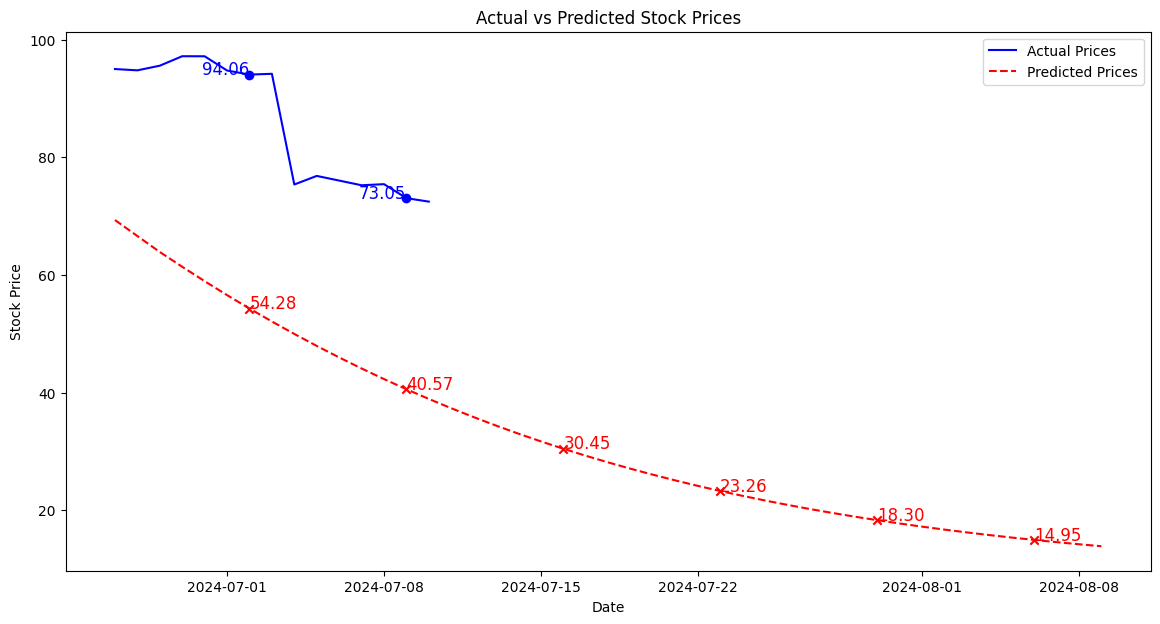

In [5]:
# Plotting the graph
plt.figure(figsize=(14, 7))
plt.plot(date_range_actual, actual_prices, color='blue', label='Actual Prices')
plt.plot(date_range_predicted, predicted_prices, color='red', linestyle='--', label='Predicted Prices')

# Adding labels for specific days
plt.scatter(date_range_actual[6], actual_prices[6], color='blue', marker='o')
plt.scatter(date_range_actual[13], actual_prices[13], color='blue', marker='o')
plt.scatter(date_range_predicted[6], predicted_prices[6], color='red', marker='x')
plt.scatter(date_range_predicted[13], predicted_prices[13], color='red', marker='x')
plt.scatter(date_range_predicted[20], predicted_prices[20], color='red', marker='x')
plt.scatter(date_range_predicted[27], predicted_prices[27], color='red', marker='x')
plt.scatter(date_range_predicted[34], predicted_prices[34], color='red', marker='x')
plt.scatter(date_range_predicted[41], predicted_prices[41], color='red', marker='x')

plt.text(date_range_actual[6], actual_prices[6], f'{actual_prices[6]:.2f}', color='blue', fontsize=12, ha='right')
plt.text(date_range_actual[13], actual_prices[13], f'{actual_prices[13]:.2f}', color='blue', fontsize=12, ha='right')
plt.text(date_range_predicted[6], predicted_prices[6], f'{predicted_prices[6]:.2f}', color='red', fontsize=12, ha='left')
plt.text(date_range_predicted[13], predicted_prices[13], f'{predicted_prices[13]:.2f}', color='red', fontsize=12, ha='left')
plt.text(date_range_predicted[20], predicted_prices[20], f'{predicted_prices[20]:.2f}', color='red', fontsize=12, ha='left')
plt.text(date_range_predicted[27], predicted_prices[27], f'{predicted_prices[27]:.2f}', color='red', fontsize=12, ha='left')
plt.text(date_range_predicted[34], predicted_prices[34], f'{predicted_prices[34]:.2f}', color='red', fontsize=12, ha='left')
plt.text(date_range_predicted[41], predicted_prices[41], f'{predicted_prices[41]:.2f}', color='red', fontsize=12, ha='left')

plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()